## Case Study: Option Valuation with Monte Carlo

### 1. Black Scholes Analytical

In [1]:
from math import log, exp, sqrt
from scipy.stats import norm

- 看涨期权定价公式：C = S*N(d1) - Le^(-rT)N(d2)


- Stats.norm.cdf(): N()正态分布变量累积概率分布函数

In [2]:
#Value of Call Option
def priceCallOptionAnalytical(S0, K, T, r, q, sigma):
    d1 = (log(S0/K) + (r-q + 0.5*sigma*sigma)*T)/sigma*sqrt(T)
    d2 = (log(S0/K) + (r-q + 0.5*sigma*sigma)*T)/sigma*sqrt(T)
    value = S0*exp(-q*T)*norm.cdf(d1,0.0,1.0)-K*exp(-r*T)*norm.cdf(d2,0.0,1.0)
    return value

#sigma: volatility 年度化方差

In [3]:
priceCallOptionAnalytical(100,90,1,0.05,0.0,0.1)

13.606563046810876

In [4]:
%timeit priceCallOptionAnalytical

23.6 ns ± 0.98 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### 2. Basic Python

Python计算仍基于BSM，模型中的股票指数在风险中立的情况下遵循随机微分方程SDE的布朗运动。 
- 随机微分方程： dSt = rStdt + σStdZt; Zt服从布朗运动的随机变量


In [5]:
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [6]:
fig = plt.figure(figsize=(100,100))
fig.savefig('/Users/yangfeilin/Desktop/pic1.png')

<Figure size 7200x7200 with 0 Axes>

In [7]:
%%html
<img src="/Users/yangfeilin/Desktop/pic2.png ",width=400,height=400>

课上的例子是用高斯分布进行蒙特卡洛模拟

In [8]:
#Monte Carlo evaluation can be done easily
import random

In [9]:
def priceCallOptionMC(S0,K,T,r,q,sigma,numPaths):
    payOff = 0.0
    for i in range(0,numPaths):
        z = random.gauss(0,1)
        S = S0 * exp((r-q-sigma*sigma/2.0)*T + sigma *sqrt(T)*z)
        payOff += max(0, S-K)
    value = payOff * exp(-r*T)/numPaths
    return value

#numPath时间间隔上的模拟路径

In [10]:
priceCallOptionMC(100, 90, 1, 0.05, 0.0, 0.1, 10000)

14.815990163531659

In [11]:
#RunTime Comparision
%timeit priceCallOptionMC(100, 90, 1, 0.05, 0.0, 0.1, 10000)

12.1 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit priceCallOptionAnalytical(100,90,1,0.05,0.0,0.1)

203 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Scipy win!

### 3.Numpy Vectorization

Vectorization makes Numpy faster! simply one-dimensional loop over paths

In [13]:
import numpy as np

In [14]:
def priceCallOptionMC_Numpy(S0,K,T,r,q,sigma,numPaths):
    z = np.random.normal(size=numPaths, loc=0.0, scale=1.0)
    S = S0*np.exp((r-q-sigma*sigma/2.0)*T + sigma*sqrt(T)*z)
    payOff = np.maximum(S-K,0)
    value = np.sum(payOff)/numPaths * np.exp(-r*T)
    return value

#Memory intensive due to holding memories

In [15]:
priceCallOptionMC_Numpy(100, 90, 1, 0.05, 0.0, 0.1, 10000)

14.774683709432038

In [16]:
%timeit priceCallOptionMC_Numpy(100, 90, 1, 0.05, 0.0, 0.1, 10000)

443 µs ± 43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 4. Numba JIT 

In [ ]:
def priceCallOptionMC(S0,K,T,r,q,sigma,numPaths):
    payOff = 0.0
    for i in range(0,numPaths):
        z = random.gauss(0,1)
        S = S0 * exp((r-q-sigma*sigma/2.0)*T + sigma *sqrt(T)*z)
        payOff += max(0, S-K)
    value = payOff * exp(-r*T)/numPaths
    return value

In [17]:
from numba import njit
@njit
def priceCallOptionMC_Numba(S0,K,T,r,q,sigma,numPaths):
    payOff = 0.0
    for i in range(0,numPaths):
        z = random.gauss(0,1)
        S = S0*exp((r-q-sigma*sigma/2.0)*T + sigma*sqrt(T)*z)
        payOff += max(0, S-K)
    value = payOff * exp(-r*T)/numPaths
    return value

In [18]:
priceCallOptionMC_Numba(100,90,1,0.05,0.0,0.1,10000)

14.545297369359387

In [19]:
%timeit priceCallOptionMC_Numba(100,90,1,0.05,0.0,0.1,10000)

521 µs ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Conclusion
- Numba, Python fast

## Case studies: Bond Yield Curves Fitting and Interpolation

### 1. Generate Cashflow Times

In [20]:
import math

In [21]:
def flow_times(maturity, frequency):
    small = 1e-10  
    #If 0, then the first payment time date will be 0
    num_payment_minus_one = int(maturity * frequency - small)
    first_payment = maturity - num_payment_minus_one / frequency
    times = np.linspace(first_payment, maturity, num_payment_minus_one +1)
    return times

In [22]:
flow_times(5,1)

array([1., 2., 3., 4., 5.])

In [23]:
flow_times(5,2)

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [24]:
flow_times(5.1,1)

array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1])

### 2.Calculate Full Bond Price from Yield

In [25]:
#Use Lambda function
def bondFullPriceFromYield(y,maturity,coupon,frequency):
    payment_times = flow_times(maturity,frequency)
    price = 0.0
    df = 1.0     #CF discount factor
    for t in payment_times:
        df = 1.0/(1.0+y/frequency)**(t*frequency)
        price += (coupon/frequency)*df
    price += df
    return price

#按照单元计算，par is 1 unit

In [26]:
bondFullPriceFromYield(0.05, 10, 0.05,2)

1.0000000000000016

In [27]:
def bondFullPriceToYield2(fullPrice, maturity,coupon,frequency):
    paymentTimes = flow_times(maturity, frequency)
    def ytm_func(y):
        p = 0.0
        for pmtTimes in paymentTimes:
            p = p + (coupon/frequency)/(1.0+y/frequency)**(frequency*pmtTime)
        p+p+1.0/(1.0+y/frequency)**(frequency*paymentTimes[-1])
        diff=p-fullPrice
        return diff
    initial_guess = 0.05
    return optimize.newton(ytm_func, initial_guess)

In [28]:
#Calculating accrued interest
def accruedinterest(maturity, coupon, frequency):
    payment_times = flow_times(maturity, frequency)
    accrued_period = 1.0/frequency - payment_times[0]
    return accrued_period * coupon

In [29]:
accruedinterest(3, 0.05,1)

0.0

In [30]:
accruedinterest(3.2, 0.05,2)

0.014999999999999993

### 3.Bond Price Action

Assuming the yield is constant...

In [31]:
import matplotlib.pyplot as plt

def plotFullPriceAction(y, maturity,coupon, frequency):
    calendar_times = np.linspace(0.0, maturity, 1001)
    #分散多个区间
    fullprices = []
    cleanprices = []  
    for t in calendar_times:
        years_to_maturity = maturity - t
        full_price = bondFullPriceFromYield(y, years_to_maturity,coupon,frequency)
        accrued = accruedinterest(years_to_maturity,coupon,frequency)
        clean_price = full_price - accrued
        fullprices.append(full_price)
        cleanprices.append(clean_price)
        
    #Plotting code
    plt.plot(calendar_times, fullprices, label = "full price")
    plt.plot(calendar_times, cleanprices, label = "clean price")
    plt.legend()

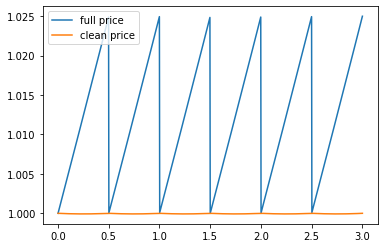

In [32]:
plotFullPriceAction(0.05, 3, 0.05, 2)

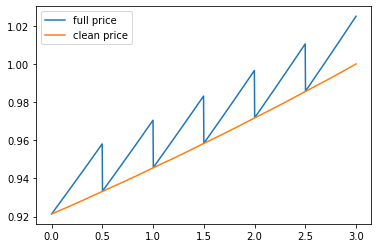

In [33]:
plotFullPriceAction(0.08, 3, 0.05, 2)

### 4. Loading Bond Data

In [34]:
import pandas as pd

In [37]:
df = pd.read_csv('./data/giltBondPrices.txt',sep='\t')
df

,epic,description,coupon,maturity,bid,ask,change,income yield,gross redemption yield
0,TR13,Uk Gilt Treasury Stk,4.50,07-Mar-13,101.92,102.07,-0.01,4.41,0.22
1,T813,Uk Gilt Treasury Stk,8.00,27-Sep-13,107.86,107.98,-0.03,7.41,0.23
2,TR14,Uk Gilt Treasury Stk,2.25,07-Mar-14,102.90,103.05,0.01,2.18,0.22
3,T514,Uk Gilt Treasury Stk,5.00,07-Sep-14,109.28,109.43,0.02,4.57,0.23
4,TR15,Uk Gilt Treasury Stk,2.75,22-Jan-15,105.57,105.68,0.05,2.60,0.33
5,T4T,Uk Gilt Treasury Stk,4.75,07-Sep-15,112.92,113.04,0.04,4.20,0.35
6,TY8,Uk Gilt Treasury Stk,8.00,07-Dec-15,124.39,124.55,0.04,6.43,0.34
7,TS16,Uk Gilt Treasury Stk,2.00,22-Jan-16,104.92,105.04,0.07,1.91,0.49
8,T16,Uk Gilt Treasury Stk,4.00,07-Sep-16,113.44,113.55,0.08,3.52,0.56
9,TR17,Uk Gilt Treasury Stk,8.75,25-Aug-17,138.48,138.66,0.14,6.31,0.77


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 9 columns):
epic                      33 non-null object
description               33 non-null object
coupon                    33 non-null float64
maturity                  33 non-null object
bid                       33 non-null float64
ask                       33 non-null float64
change                    33 non-null float64
income yield              33 non-null float64
gross redemption yield    33 non-null float64
dtypes: float64(6), object(3)
memory usage: 2.4+ KB


In [39]:
#Add a new column with the mid price
df['mid'] = (df['bid'] + df['ask'])/2.0

In [40]:
df.head(2)

,epic,description,coupon,maturity,bid,ask,change,income yield,gross redemption yield,mid
0,TR13,Uk Gilt Treasury Stk,4.5,07-Mar-13,101.92,102.07,-0.01,4.41,0.22,101.995
1,T813,Uk Gilt Treasury Stk,8.0,27-Sep-13,107.86,107.98,-0.03,7.41,0.23,107.920


### 5. Calculating Yield from Price - Part I

In [53]:
import pandas as pd
import numpy as np
from scipy import optimize

In [54]:
def bondFullPriceToYield(fullprice, maturity, coupon, frequency):
    payment_times = flow_times(maturity, frequency)
    ytm_func = lambda y:\
    sum([(coupon/frequency)/(1.0+y/frequency)**(frequency*pmt_time) for pmt_time in payment_times]) + \
    1.0/(1.0+y/frequency)**(frequency*payment_times[-1]) - fullprice
   
    initial_guess = 0.05
    return optimize.newton(ytm_func, initial_guess)

In [55]:
bondFullPriceToYield(1.0, 10, 0.05, 2)

0.04999999999999995

In [56]:
def bondFullPriceToYield2(fullprice, maturity, coupon,frequency):
    payment_times = flow_times(maturity, frequency)
    def ytm_func(y):
        p = 0.0
        for pmtTime in payment_times:
            p = p+(coupon/frequency)/(1.0+y/frequency)**(frequency*pmtTime)
        p = p+1.0/(1.0+y/frequency)**(freqency*payment_times[-1])
        diff = p-fullprice
        return diff
    initial_guess = 0.05
    return optimize.newton(ytm_func, initial_guess)
    

In [59]:
def yearFrac(d1, d2, daysInYear = 365.252):
    day_diff = d2 - d1
    frac = day_diff.days / daysInYear
    return frac

In [61]:
import datetime as dt
ytms = []
yearsToMaturities = []
fullPrices = []
accrueds = []
settlement = dt.datetime(2012,9,19)

for index, bond in df.iterrows():
    
    dateString = bond['maturity']
    #The bond maturity date is not a "date", need to transform here
    maturityDt = dt.datetime.strptime(dateString, "%d-%b-%y")
    yearsToMaturity = yearFrac(settlement, maturityDt)
    
    coupon = bond['coupon']/100.0
    frequency = 2
    cleanPrice = bond['mid']/100.0
    
    accrued = accruedinterest(yearsToMaturity, coupon, frequency)
    fullPrice = cleanPrice + accrued
    
    ytm = bondFullPriceToYield(fullPrice, yearsToMaturity, coupon, frequency)
    
    fullPrices.append(fullPrice*100)
    ytms.append(ytm*100)
    yearsToMaturities.append(yearsToMaturity)
    accrueds.append(accrued)

In [62]:
import matplotlib.pyplot as plt

In [65]:
df['ytm'] = ytms
df['yearsToMaturity'] = yearsToMaturities
df['fullPrice'] = fullPrices
df['accd'] = accrueds

### 6.Yield Curve Points

Text(0, 0.5, 'Yield to Maturity')

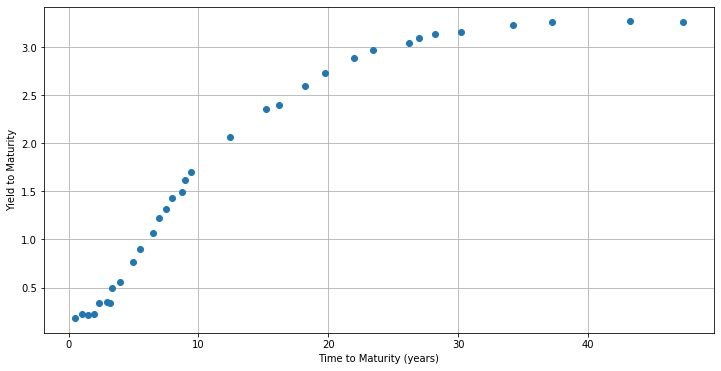

In [66]:
plt.figure(figsize=(12,6))
plt.plot(df['yearsToMaturity'],df['ytm'],'o')
plt.grid(True)
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Yield to Maturity')

### 7. Fit and Plot

In [80]:
#Polynomial Fit to the Curve
def fitAndPlot(t,y,d):
    #t is the vector of years and y is the vector of yields
    coeffs = np.polyfit(t, y, deg=d)
    ry = np.polyval(coeffs,t)
    
    plt.figure(figsize=(12,8))
    plt.plot(t,y,'o')
    plt.plot(t,ry,'r',label = 'Fit')
    plt.legend(loc=0)
    plt.grid(True)
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield to Maturity')

/Users/yangfeilin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


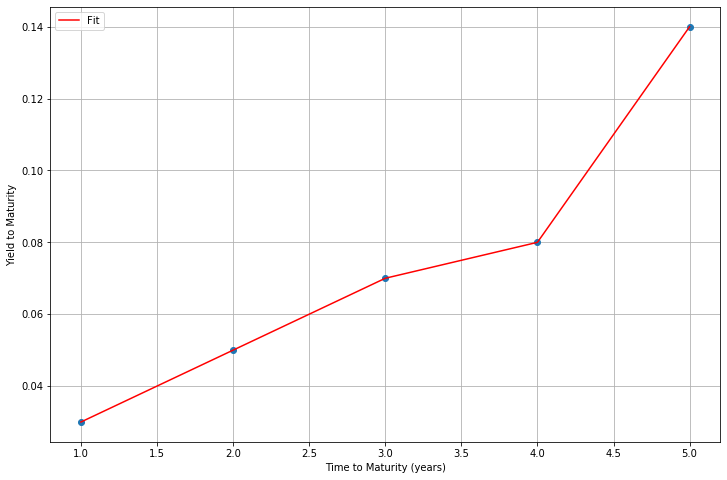

In [83]:
fitAndPlot((1,2,3,4,5),(0.03,0.05,0.07,0.08,0.14),7)

## Case Studies: Mean-Variance Portfolio Optimisation

### 1. Stock Price Data

In [86]:
timeSeriesData = pd.read_csv('./data/timeSeriesData.csv')

In [87]:
import pandas as pd
pd.__version__

'0.25.1'

In [88]:
timeSeriesData

,Unnamed: 0,Date,Open,High,Low,Close,Volume,OpenInt,Ticker
0,0,1970-01-02,0.7587,0.8092,0.7587,0.8092,753088,0,ba
1,1,1970-01-05,0.8263,0.8429,0.8263,0.8345,879203,0,ba
2,2,1970-01-06,0.8429,0.8598,0.8429,0.8429,1607067,0,ba
3,3,1970-01-07,0.8429,0.8598,0.8429,0.8512,767501,0,ba
4,4,1970-01-08,0.8512,0.8512,0.8263,0.8429,958476,0,ba
...,...,...,...,...,...,...,...,...,...
184557,12069,2017-11-06,82.5360,83.1010,82.2980,82.9820,9360223,0,xom
184558,12070,2017-11-07,82.9720,83.0510,82.3380,82.8140,8508720,0,xom
184559,12071,2017-11-08,82.5960,82.7340,82.1000,82.7050,8771697,0,xom
184560,12072,2017-11-09,82.5360,83.3680,82.3180,83.2000,10575654,0,xom


In [89]:
tickers = timeSeriesData['Ticker'].unique()
tickers

array(['ba', 'dis', 'ge', 'hpq', 'ibm', 'intc', 'jnj', 'jpm', 'ko', 'mcd',
       'mo', 'mrk', 'pg', 'utx', 'xom'], dtype=object)

In [90]:
closePrices = timeSeriesData[['Date','Ticker','Close']]

In [91]:
closePrices.set_index('Date')

,Ticker,Close
Date,,
1970-01-02,ba,0.8092
1970-01-05,ba,0.8345
1970-01-06,ba,0.8429
1970-01-07,ba,0.8512
1970-01-08,ba,0.8429
...,...,...
2017-11-06,xom,82.9820
2017-11-07,xom,82.8140
2017-11-08,xom,82.7050


### 2. Align the Times Series

In [92]:
#重新调整数据的分布格式, 从竖着的转换成横着的
df_all = pd.DataFrame()

for ticker in tickers:
    df_ticker = closePrices[closePrices.Ticker == ticker]
    df_ticker = df_ticker.set_index('Date')
    df_ticker.columns = [['Ticker', ticker]]
    df_ticker = df_ticker.drop(['Ticker'], axis = 1)  
    #删除的第一列都是ticker，跟第一行的重复！
    df_all = pd.concat([df_ticker,df_all], axis=1, join="outer")
    df_all = df_all.dropna()  #drop NA value

/Users/yangfeilin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [93]:
df_all

,xom,utx,pg,mrk,mo,mcd,ko,jpm,jnj,intc,ibm,hpq,ge,dis,ba
1972-01-07,1.8452,0.31680,1.9119,0.7077,0.04379,0.7691,0.9870,2.9672,0.9929,0.01592,14.080,0.27561,1.0707,1.0770,0.5815
1972-01-14,1.8132,0.32548,1.9523,0.6998,0.04379,0.7448,0.9870,3.0419,0.9685,0.00791,14.546,0.27943,1.0467,1.1319,0.6492
1972-01-21,1.8452,0.33400,1.9927,0.6840,0.04379,0.7530,0.9747,3.0088,0.9767,0.00791,15.305,0.29095,1.0467,1.1775,0.6576
1972-01-24,1.7969,0.32548,1.9605,0.6840,0.04379,0.7448,0.9870,2.9921,0.9602,0.00791,14.990,0.29095,1.0305,1.1683,0.6323
1972-01-25,1.8050,0.33400,1.9523,0.6998,0.04379,0.7448,0.9951,2.9672,0.9685,0.00791,15.215,0.28705,1.0305,1.1683,0.6405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06,82.9820,120.39000,86.0500,55.8800,63.45000,170.0700,45.4700,100.7800,139.7600,46.70000,149.350,21.44000,20.1300,100.6400,262.6600
2017-11-07,82.8140,120.75000,86.9800,55.5900,64.31000,170.7700,45.9400,98.7500,139.7700,46.78000,149.850,21.38000,20.2100,101.6100,264.7100
2017-11-08,82.7050,120.28000,87.5800,56.5800,64.59000,170.1000,46.1800,97.6400,141.3200,46.70000,150.070,21.42000,20.1200,101.1800,264.1500
2017-11-09,83.2000,118.37000,87.7800,56.2100,64.51000,167.0000,46.2300,97.6300,140.3500,46.30000,150.300,21.34000,19.9900,102.6800,262.7000


### 3. Extract the Returns

In [97]:
#Closing prices but need return
returns = df_all.pct_change(periods=1)
returns.dropna(inplace=True)
returns.head()

,xom,utx,pg,mrk,mo,mcd,ko,jpm,jnj,intc,ibm,hpq,ge,dis,ba
1972-01-14,-0.017342,0.027399,0.021131,-0.011163,0.0,-0.031595,0.000000,0.025175,-0.024574,-0.503141,0.033097,0.013860,-0.022415,0.050975,0.116423
1972-01-21,0.017648,0.026177,0.020694,-0.022578,0.0,0.011010,-0.012462,-0.010881,0.008467,0.000000,0.052179,0.041227,0.000000,0.040286,0.012939
1972-01-24,-0.026176,-0.025509,-0.016159,0.000000,0.0,-0.010890,0.012619,-0.005550,-0.016894,0.000000,-0.020582,0.000000,-0.015477,-0.007813,-0.038473
1972-01-25,0.004508,0.026177,-0.004183,0.023099,0.0,0.000000,0.008207,-0.008322,0.008644,0.000000,0.015010,-0.013404,0.000000,0.000000,0.012969
1972-01-26,0.004543,-0.025509,-0.004098,0.000000,0.0,0.011010,-0.004120,-0.005662,0.008467,0.000000,0.007558,0.000000,-0.015429,0.007875,0.013583


In [99]:
#Using pct_change function to calculate daily returns
#Pass into the dataframe selected
assetReturns = returns.mean()
assetCovariance = returns.cov()
assetCorrelations = returns.corr()

In [100]:
assetReturns

xom     0.000434
utx     0.000662
pg      0.000433
mrk     0.000514
mo      0.000872
mcd     0.000608
ko      0.000449
jpm     0.000537
jnj     0.000534
intc    0.001281
ibm     0.000338
hpq     0.000636
ge      0.000398
dis     0.000596
ba      0.000727
dtype: float64

In [101]:
assetCovariance

,xom,utx,pg,mrk,mo,mcd,ko,jpm,jnj,intc,ibm,hpq,ge,dis,ba
xom,0.000207,0.000092,0.000075,0.000083,0.000076,0.000078,0.000087,0.000102,0.000080,0.000110,0.000084,0.000099,0.000103,0.000103,0.000094
utx,0.000092,0.000297,0.000079,0.000089,0.000079,0.000093,0.000086,0.000138,0.000082,0.000144,0.000101,0.000135,0.000136,0.000129,0.000153
pg,0.000075,0.000079,0.000198,0.000091,0.000084,0.000090,0.000103,0.000088,0.000091,0.000098,0.000073,0.000088,0.000099,0.000095,0.000081
mrk,0.000083,0.000089,0.000091,0.000270,0.000093,0.000093,0.000097,0.000110,0.000118,0.000127,0.000085,0.000108,0.000112,0.000110,0.000097
mo,0.000076,0.000079,0.000084,0.000093,0.000479,0.000097,0.000094,0.000087,0.000084,0.000129,0.000081,0.000099,0.000097,0.000100,0.000088
mcd,0.000078,0.000093,0.000090,0.000093,0.000097,0.000285,0.000102,0.000103,0.000091,0.000137,0.000095,0.000117,0.000114,0.000131,0.000104
ko,0.000087,0.000086,0.000103,0.000097,0.000094,0.000102,0.000231,0.000097,0.000097,0.000113,0.000082,0.000101,0.000111,0.000112,0.000092
jpm,0.000102,0.000138,0.000088,0.000110,0.000087,0.000103,0.000097,0.000471,0.000089,0.000181,0.000129,0.000168,0.000183,0.000161,0.000136
jnj,0.000080,0.000082,0.000091,0.000118,0.000084,0.000091,0.000097,0.000089,0.000210,0.000114,0.000081,0.000097,0.000106,0.000100,0.000089
intc,0.000110,0.000144,0.000098,0.000127,0.000129,0.000137,0.000113,0.000181,0.000114,0.001218,0.000186,0.000283,0.000183,0.000185,0.000163


In [102]:
assetCorrelations

,xom,utx,pg,mrk,mo,mcd,ko,jpm,jnj,intc,ibm,hpq,ge,dis,ba
xom,1.000000,0.369598,0.367588,0.349170,0.239697,0.319864,0.397042,0.327362,0.382954,0.219142,0.355553,0.301986,0.425028,0.359436,0.327034
utx,0.369598,1.000000,0.326554,0.316308,0.209138,0.319626,0.327082,0.369998,0.328184,0.239633,0.360143,0.344072,0.467937,0.377026,0.446710
pg,0.367588,0.326554,1.000000,0.395446,0.273143,0.379844,0.480091,0.286607,0.444299,0.198914,0.318634,0.273373,0.415593,0.337365,0.287300
mrk,0.349170,0.316308,0.395446,1.000000,0.259381,0.335509,0.387692,0.309680,0.497376,0.221125,0.318329,0.288265,0.404310,0.336042,0.296695
mo,0.239697,0.209138,0.273143,0.259381,1.000000,0.262992,0.282194,0.182166,0.263848,0.168287,0.226907,0.199189,0.263730,0.229960,0.202105
mcd,0.319864,0.319626,0.379844,0.335509,0.262992,1.000000,0.397068,0.281217,0.369825,0.231891,0.346157,0.304340,0.401209,0.388684,0.308409
ko,0.397042,0.327082,0.480091,0.387692,0.282194,0.397068,1.000000,0.292768,0.439826,0.212920,0.331319,0.290841,0.432993,0.369746,0.304591
jpm,0.327362,0.369998,0.286607,0.309680,0.182166,0.281217,0.292768,1.000000,0.281268,0.239013,0.364169,0.339637,0.498894,0.371879,0.315204
jnj,0.382954,0.328184,0.444299,0.497376,0.263848,0.369825,0.439826,0.281268,1.000000,0.224380,0.341439,0.294997,0.432813,0.347480,0.307419
intc,0.219142,0.239633,0.198914,0.221125,0.168287,0.231891,0.212920,0.239013,0.224380,1.000000,0.326673,0.356416,0.310108,0.266734,0.234743


### 3. Portfolio Measure of Rish and Return

Generate random portfolios and determine their distribution in mean-volatility space

In [103]:
#Only pass the weight vector explicitly
def portfolioVariance(weights):
    weights = np.array(weights)
    var = np.dot(weights.T, np.dot(assetCovariance * 252, weights))
    return var

def portfolioVolatility(weights):
    return np.sqrt(np.dot(weights.T,np.dot(assetCovariance*252, weights)))

def portfolioReturn(weights):
    return np.sum(assetReturns * weights) *252

def portfolioSharpeRatio(weights):
    return (portfolioReturn(weights) - rfr) / portfolioVolatility(weights)

In [104]:
#Risk free rate
rfr = 0.015

In [105]:
#Generate different portfolio weightings and store their mena return and volatility
portofolioReturns = []
portfolioVolatilities = []
portfolioVariances = []
portfolioSharpeRatios = []

### 4. Generate the Efficient Frontier

Loop over returns and find the portfolio that minimises the portfolio volatility

Include a constraint that enfores the return given
With the constraint to have the weights sum to 1 we have two constraints which 

In [106]:
import numpy as mp
import scipy.optimize as sco

In [110]:
# This means that we need to include a constraint that enforces the return given by variable ret
# With the constraint to have the weights sum to 1 we have two constraints which we write as follows
cons = ({'type':'eq','fun': lambda x: portfolioReturn(x) - tret},
        {'type':'eq','fun': lambda x: np.sum(x) - 1})
 #lambda后面的公式=0

In [111]:
#获得范围
minRet = min(assetReturns * 252)
maxRet = max(assetReturns * 252)

trets = np.linspace(minRet, maxRet, 50)  
tvols = []  #Volatility of the efficient frontier
initialWeights = np.ones(numAssets)
bnds = tuple((0,1) for x in initialWeights)


#2 Constraints:
for tret in trets: 
    cons = ({'type': 'eq', 'fun': lambda x:  portfolioReturn(x) - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

    res = sco.minimize(portfolioVolatility, initialWeights, method='SLSQP', bounds=bnds, constraints=cons)
    frontierWeights = res['x']
    frontierRet = portfolioReturn(frontierWeights)
    frontierVol = portfolioVolatility(frontierWeights)    
    tvols.append(res['fun'])

ValueError: operands could not be broadcast together with shapes (15,) (6,) 

In [112]:
import matplotlib.pyplot as plt

ValueError: x and y must be the same size

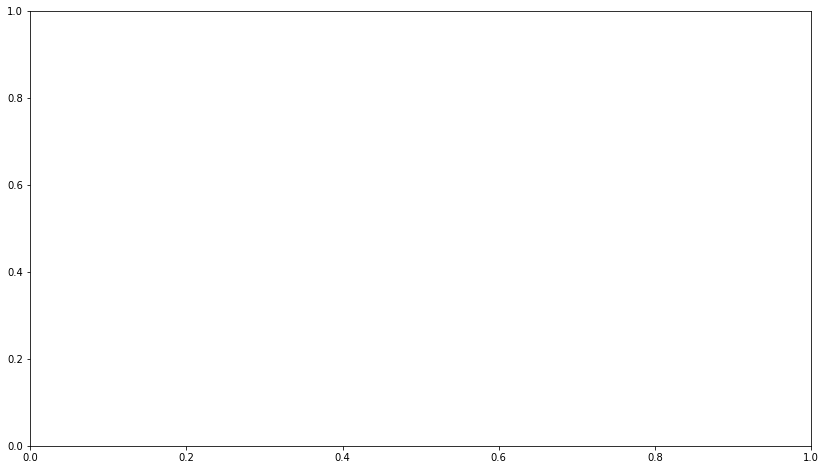

In [113]:
plt.figure(figsize=(14,8))
plt.scatter(tvols, trets, c=(tret-rfr)/tvols, marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe ratio')

# Python Modules

## Option Value

In [1]:
#import FinUtils
from math import exp, log, sqrt
from scipy import optimize
from scipy.stats import norm
from datetime import date

DAYS_IN_YEAR = 365.242

In [2]:
def f(volatility, *args):

    self = args[0]
    valueDate = args[1]
    stockPrice = args[2]
    divYield = args[3]
    interestRate = args[4]
    value = args[5]

    objFn = self.value(valueDate,stockPrice,divYield,volatility,interestRate) - value

    return objFn


In [3]:
class Option(object):

    def __init__ (self, expiry_date, strike_price, option_type ):

        if isinstance(expiry_date, date) == False:        
            print("Expiry date is not a date")

        self._expiry_date = expiry_date
        self._strike_price = float(strike_price)
        self._option_type = option_type.upper()
        
        if self._option_type != "CALL" and self._option_type != "PUT":
            print("Unknown option type")

In [4]:
    def value(self, value_date, stock_price, interest_rate, 
              dividend_yield, volatility ):

        t = abs(self._expiry_date - value_date).days / DAYS_IN_YEAR
        r = interest_rate; q = dividend_yield; s = stock_price; 
        k = self._strike_price; v = volatility
        
        d1 = (log(s/k) + (r - q + v*v / 2.0) * t) / (v * sqrt(t))
        d2 = (log(s/k) + (r - q - v*v / 2.0) * t) / (v * sqrt(t))

        if self._option_type == "CALL":
            v = s * exp(-q * t) * norm.cdf(d1)
            v = v - k * exp(-r * t) * norm.cdf(d2)
        elif self._option_type == "PUT":
            v = k * exp(-r * t) * norm.cdf(-d2)
            v = v - s * exp(-q * t) * norm.cdf(-d1)

        return v

In [5]:
    def impliedVolatility(self, value_date, option_mkt_value, stock_price,
                          dividend_yield, interest_rate):

        argtuple = (self, value_date, stock_price, dividend_yield, 
                    interest_rate, option_mkt_value)

        sigma = optimize.newton(f,x0=0.2, args=argtuple, tol=1e-8, maxiter=50)
        return sigma

In [8]:
if __name__ == "__main__":
    
    import matplotlib.pyplot as plt

    expiry_date = 10; # date(2022, 6, 1)
    stockPrice = 100
    volatility = 0.30
    interest_rate = 0.05
    dividend_yield = 0.0

    stockPrices = range(50,150)
    callOptionValues = []
    putOptionValues = []
    value_date = date(2022, 1, 1)

    for stockPrice in stockPrices:
        callOption = Option(expiry_date, 100.0, "CALL")
        value = callOption.value(value_date, stockPrice, interest_rate, dividend_yield, volatility)
        callOptionValues.append(value)

    for stockPrice in stockPrices:
        putOption = Option(expiry_date, 100.0, "PUT")
        value = putOption.value(value_date, stockPrice, interest_rate, dividend_yield, volatility)
        putOptionValues.append(value)

    plt.figure()
    plt.plot(stockPrices, callOptionValues, color = 'b', label="Call Option")
    plt.plot(stockPrices, putOptionValues, color = 'r', label = "Put Option")
    plt.xlabel("Stock Price")
    plt.legend(loc='best')

    callOption = Option(expiry_date, 100.0, "CALL")
    value = callOption.value(value_date, stockPrice, dividend_yield, volatility, interest_rate)
    impliedVol = callOption.impliedVolatility(value_date, value, stockPrice, dividend_yield, 
                                              interest_rate)
    print("Implied Vol %9.5f" % impliedVol) 


Expiry date is not a date


TypeError: unsupported operand type(s) for -: 'int' and 'datetime.date'